In [1]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

rootFolder = '/home/fernando/S1_netpyne/sim/'
# rootFolder = os.getcwd()
os.chdir(rootFolder)
print(rootFolder)
folder = os.listdir('cell_data/')
folder = sorted(folder)

savedata = 1 # Save Netpyne and BBP soma_voltage

/home/fernando/S1_netpyne/sim/


In [2]:
!nrnivmodl mod

/home/fernando/S1_netpyne/sim
Mod files: "mod/cadad.mod" "mod/CaDynamics_E2.mod" "mod/Ca_HVA.mod" "mod/Ca_LVAst.mod" "mod/Ca.mod" "mod/DetAMPANMDA.mod" "mod/DetGABAAB.mod" "mod/HH2.mod" "mod/htc.mod" "mod/Ih.mod" "mod/Im.mod" "mod/IT2.mod" "mod/IT.mod" "mod/KdShu2007.mod" "mod/kl.mod" "mod/K_Pst.mod" "mod/K_Tst.mod" "mod/MyExp2SynBB.mod" "mod/MyExp2SynNMDABB.mod" "mod/Nap_Et2.mod" "mod/NaTa_t.mod" "mod/NaTs2_t.mod" "mod/ProbAMPANMDA_EMS.mod" "mod/ProbGABAAB_EMS.mod" "mod/SK_E2.mod" "mod/SKv3_1.mod" "mod/StochKv_deterministic.mod" "mod/StochKv.mod" "mod/tia.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/fernando/anaconda3/envs/p3/lib/python3.9/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /home/fernando/anaconda3/envs/p3/lib/python3.9/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  

In [3]:
folder[1025:1035]

['L6_TPC_L4_cADpyr231_1',
 'L6_TPC_L4_cADpyr231_2',
 'L6_TPC_L4_cADpyr231_3',
 'L6_TPC_L4_cADpyr231_4',
 'L6_TPC_L4_cADpyr231_5',
 'L6_UTPC_cADpyr231_1',
 'L6_UTPC_cADpyr231_2',
 'L6_UTPC_cADpyr231_3',
 'L6_UTPC_cADpyr231_4',
 'L6_UTPC_cADpyr231_5']

In [5]:
def loadTemplateName(cellnumber):     
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[:-1]        
    templatename=templatename[14:]
    return templatename

In [6]:
def runneuron(cellnumber):
        
    os.chdir(rootFolder)
    
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)

    from cellwrapper3 import loadCell #StochKv_deterministic.mod
    cell=loadCell(cellName, cellTemplateName)

    soma = cell.soma[0]

    BBPTraces = []
    BBPTracesList = []
    
    i=0
    for x in current_content.split():
        i=i+1   

        stimulus = neuron.h.IClamp(0.5, sec=soma)
        stimulus2 = neuron.h.IClamp(0.5, sec=soma)

        stimulus.dur = durationstim # ms
        stimulus.delay = delaystim  # ms     
        stimulus2.dur = timesimulation # ms
        stimulus2.delay = 0  # ms    
        
        if float(x)<0:
            stimulus.amp = float(x)
            stimulus2.amp = 0
        else:
            stimulus.amp = float(x)
            stimulus2.amp = holding_current

        recordings = {}

        recordings['time'] = neuron.h.Vector()
        recordings['soma(0.5)'] = neuron.h.Vector()

        recordings['time'].record(neuron.h._ref_t, 0.1)
        recordings['soma(0.5)'].record(cell.soma[0](0.5)._ref_v, 0.1)

        neuron.h.dt = 0.05
        neuron.h.cvode_active(0)
        neuron.h.tstop = timesimulation # ms
        neuron.h.run();

        time = np.array(recordings['time'])
        soma_voltage = np.array(recordings['soma(0.5)'])

        BBPTraces.append(soma_voltage)
        BBPTracesList.append(list(soma_voltage))
    
    return BBPTraces

In [7]:
def runneuron2(cellnumber):
        
    os.chdir(rootFolder)
    
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)

    from cellwrapper2 import loadCell #StochKv.mod
    cell=loadCell(cellName, cellTemplateName)

    soma = cell.soma[0]

    BBPTraces2 = []
    BBPTracesList2 = []

    i=0
    for x in current_content.split():
        i=i+1   
        
        stimulus = neuron.h.IClamp(0.5, sec=soma)
        stimulus2 = neuron.h.IClamp(0.5, sec=soma)

        stimulus.dur = durationstim # ms
        stimulus.delay = delaystim  # ms     
        stimulus2.dur = timesimulation # ms
        stimulus2.delay = 0  # ms    
        
        if float(x)<0:
            stimulus.amp = float(x)
            stimulus2.amp = 0
        else:
            stimulus.amp = float(x)
            stimulus2.amp = holding_current

        recordings = {}

        recordings['time'] = neuron.h.Vector()
        recordings['soma(0.5)'] = neuron.h.Vector()

        recordings['time'].record(neuron.h._ref_t, 0.1)
        recordings['soma(0.5)'].record(cell.soma[0](0.5)._ref_v, 0.1)

        neuron.h.dt = 0.05
        neuron.h.cvode_active(0)
        neuron.h.tstop = timesimulation # ms
        neuron.h.run();

        time = np.array(recordings['time'])
        soma_voltage = np.array(recordings['soma(0.5)'])

        BBPTraces2.append(soma_voltage)
        BBPTracesList2.append(list(soma_voltage))
    return BBPTraces2

In [8]:
def runnetpyne(cellnumber):

    os.chdir(rootFolder)
    from netpyne import sim
    from netpyne import specs
    import pickle

    cfg = specs.SimConfig()     
    
    cfg.duration = timesimulation ## Duration of the sim, in ms  
    cfg.dt = 0.05
    # ~ cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
    cfg.hParams = {'celsius': 34, 'v_init': -65}  
    cfg.verbose = False
    cfg.createNEURONObj = True
    cfg.createPyStruct = True
    cfg.cvode_active = False
    cfg.cvode_atol = 1e-6
    cfg.cache_efficient = True
    cfg.printRunTime = 0.5
    
    cfg.includeParamsLabel = False
    cfg.printPopAvgRates = True
    cfg.checkErrors = False
    
    allpops = ['L1_1','L1_2','L1_3','L1_4']

    cfg.recordCells = allpops  # which cells to record from
    cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
    cfg.recordStim = True
    cfg.recordTime = True
    cfg.recordStep = 0.1            

    cfg.simLabel = 'S1detailed'
    cfg.saveFolder = '.'
    # cfg.filename =                	## Set file output name
    cfg.savePickle = False         	## Save pkl file
    cfg.saveJson = False           	## Save json file
    cfg.saveDataInclude = ['simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
    cfg.backupCfgFile = None 		##  
    cfg.gatherOnlySimData = False	##  
    cfg.saveCellSecs = False			##  
    cfg.saveCellConns = False		##  

    #------------------------------------------------------------------------------
    # Analysis and plotting 
    #------------------------------------------------------------------------------
    # ~ cfg.analysis['plotTraces'] = {'include': [('L1_1',0)], 'saveFig': True, 'showFig': False, 'oneFigPer':'trace', 'overlay':False} 		
    #------------------------------------------------------------------------------
    # Cells
    #------------------------------------------------------------------------------
    cfg.cellmod =  {'L1_1': 'HH_full'}
    cfg.cellmod =  {'L1_2': 'HH_full'}
    cfg.cellmod =  {'L1_3': 'HH_full'}
    cfg.cellmod =  {'L1_4': 'HH_full'}

    #------------------------------------------------------------------------------
    # Current inputs 
    #------------------------------------------------------------------------------
    cfg.addIClamp = 1

    cfg.IClamp1 = {'pop': 'L1_1', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': holding_current}
    cfg.IClamp2 = {'pop': 'L1_2', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
    cfg.IClamp3 = {'pop': 'L1_2', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
    cfg.IClamp4 = {'pop': 'L1_3', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
    cfg.IClamp5 = {'pop': 'L1_3', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step2_current}
    cfg.IClamp6 = {'pop': 'L1_4', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
    cfg.IClamp7 = {'pop': 'L1_4', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step3_current}


    netParams = specs.NetParams()   # object of class NetParams to store the network parameters

    #------------------------------------------------------------------------------
    # Cell parameters
    #------------------------------------------------------------------------------
    #StochKv_deterministic.mod
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper3.py',
        cellName='loadCell',
        cellInstance = True,
        cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})

    #------------------------------------------------------------------------------
    # Population parameters
    #------------------------------------------------------------------------------

    netParams.popParams['L1_1'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_2'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_3'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_4'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 

    #------------------------------------------------------------------------------
    # Current inputs (IClamp)
    #------------------------------------------------------------------------------
    if cfg.addIClamp:
         for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
            params = getattr(cfg, key, None)
            [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

            #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

            # add stim source
            netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

            # connect stim source to target
            netParams.stimTargetParams[key+'_'+pop] =  {
                'source': key, 
                'conds': {'pop': pop},
                'sec': sec, 
                'loc': loc}

    sim.createSimulateAnalyze(netParams, cfg)
    
    netpyneTraces = []
    netpyneTracesList = []
    for c in range(0,4):
        netpyneTraces.append(np.array(sim.simData['V_soma']['cell_'+ str(c)]))
        netpyneTracesList.append(list(sim.simData['V_soma']['cell_'+ str(c)]))        
 
    return netpyneTraces

In [9]:
folder[1025]

'L6_TPC_L4_cADpyr231_1'

In [10]:
cellnumber = 1025 #366 #10 # 265 #916 #369 # 
cellName = folder[cellnumber]
outFolder = rootFolder+'/cell_data/'+folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
print ("CellNumber = %d" % cellnumber)
print ("CellName = %s" % cellName)
print ("TemplateName = %s" % cellTemplateName)

with open(outFolder + '/current_amps.dat') as current_file:
    current_content = current_file.read()

holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]
print ('load step1_current from current_amps.dat = %s' % step1_current)
        
durationstim = 2000
delaystim = 700
timesimulation = 3000
        
# durationstim = 400
# delaystim = 200
# timesimulation = 700

BBPTraces2 = runneuron2(cellnumber)
BBPTraces = runneuron(cellnumber)
netpyneTraces = runnetpyne(cellnumber)

CellNumber = 1025
CellName = L6_TPC_L4_cADpyr231_1
TemplateName = cADpyr231_L6_TPC_L4_3f1b0bd478
load step1_current from current_amps.dat = 0.2447808
Loading constants
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
Loading cell cADpyr231_L6_TPC_L4_3f1b0bd478
cADpyr231_L6_TPC_L4_3f1b0bd478[0]
Changed dt
Changed dt
Changed dt
Changed dt
cADpyr231_L6_TPC_L4_3f1b0bd478[0]
Changed dt
Changed dt
Changed dt
Changed dt
cADpyr231_L6_TPC_L4_3f1b0bd478[0]

Start time:  2021-08-28 17:27:21.657791

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 4 
  Done; cell creation time = 0.14 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 7 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 2 types on node 0
0.0s

Running simulation for 3000.0 ms...
0.5s
1.0s
1.5s
2.0s
2.5s
3.0s
  Done; run time = 15.36 s; real-time rat

Figure Saved in /home/fernando/S1_netpyne/sim//comparison_traces_soma_voltage_4steps_L6_TPC_L4_cADpyr231_1.png
https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/L6_TPC_L4_cADpyr/details


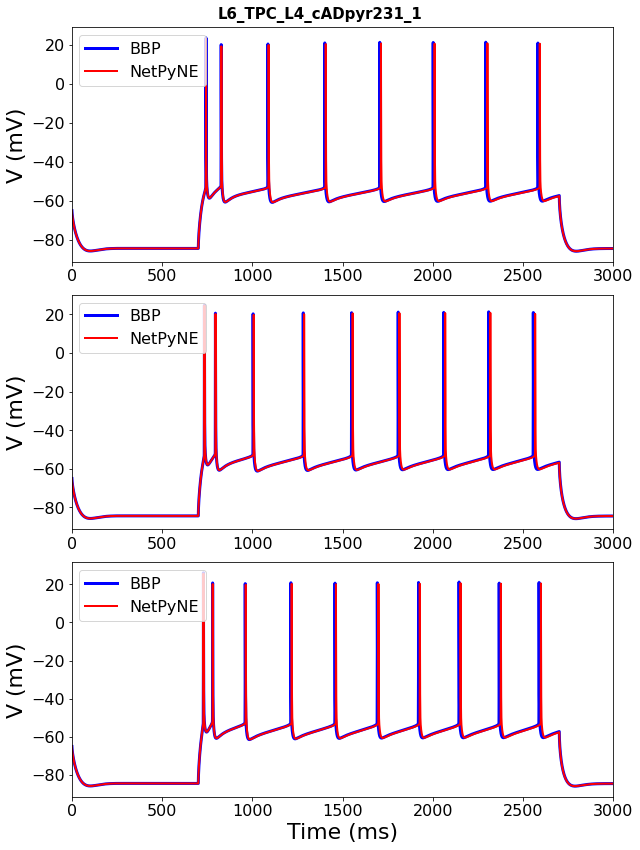

In [11]:
# plot both traces overlayed
fontsiz=22
timeRange = [0, timesimulation]
recordStep = 0.1
# ~ ylim = [-100, 40]
figSize = (9,12)
fig = plt.figure(figsize=figSize)  # Open a new figure

fig.suptitle('%s' % (cellName), fontsize=15, fontweight='bold')
                
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 
 
for c in range(1,4):
    netpyneTrace = netpyneTraces[c]
    BBPTrace = BBPTraces[c]
    BBPTrace2 = BBPTraces2[c]
    plt.subplot(3, 1, c)
    plt.ylabel('V (mV)', fontsize=fontsiz)
#     plt.plot(t[:len(BBPTrace)], BBPTrace, linewidth=3.0, linestyle=':', color='blue', label='Step %d'%(int(c+0))+', BBPdet')  # linestyle=':'
    plt.plot(t[:len(BBPTrace2)], BBPTrace2, linewidth=3.0, color='blue', label='BBP')# linestyle=':'
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, color='red', label='NetPyNE')
    plt.xlim(0, timesimulation)
    # ~ plt.ylim(ylim)
    plt.grid(False)
    plt.legend(loc='upper right', bbox_to_anchor=(0.262, 1.0), fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.xlabel('Time (ms)', fontsize=fontsiz)
plt.ion()
plt.tight_layout()
os.chdir(rootFolder)
os.chdir('../info/scripts_comparations/')
plt.savefig('Figures-comparation/comparison_traces_soma_voltage_4steps_%s.png' % cellName, facecolor = 'white' , dpi=300)
print ("Figure Saved in %s/comparison_traces_soma_voltage_4steps_%s.png" % (rootFolder,cellName))
print ("https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/%s/details" % cellName[:-5])
plt.show()

Figure Saved in /home/fernando/S1_netpyne/sim//comparison_traces_soma_voltage_4steps_L6_TPC_L4_cADpyr231_1.png
https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/L6_TPC_L4_cADpyr/details


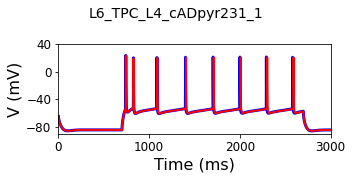

In [12]:
# plot both traces overlayed
fontsiz=16
timeRange = [0, timesimulation]
recordStep = 0.1
# ~ ylim = [-100, 40]
figSize = (5,2.5)
fig = plt.figure(figsize=figSize)  # Open a new figure

fig.suptitle('%s' % (cellName), fontsize=14)
                
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 
 
for c in range(1,2):
    netpyneTrace = netpyneTraces[c]
    BBPTrace = BBPTraces[c]
    BBPTrace2 = BBPTraces2[c]
    plt.subplot(1, 1, c)
    plt.ylabel('V (mV)', fontsize=fontsiz)
    plt.plot(t[:len(BBPTrace2)], BBPTrace2, linewidth=3.0, color='blue', label='BBP')# linestyle=':'
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=2.0, color='red', label='NetPyNE')    
#     plt.plot(t[:len(BBPTrace)], BBPTrace, linewidth=3.0, linestyle=':', color='blue', label='BBPdet')  # linestyle=':'
    plt.xlim(0, timesimulation)
    plt.ylim(-90,40)
    plt.grid(False)
#     plt.legend(loc='upper right', bbox_to_anchor=(0.255, 1.01), fontsize=11)
    plt.xticks([0,1000,2000,3000],fontsize=12)
    plt.yticks([-80,-40,0,40], fontsize=12)
plt.xlabel('Time (ms)', fontsize=fontsiz)
plt.ion()
plt.tight_layout()
os.chdir(rootFolder)
os.chdir('../info/scripts_comparations/')
plt.savefig('Figures-comparation/comparison_traces_soma_voltage_4steps_%s.png' % cellName, facecolor = 'white' , dpi=300)
print ("Figure Saved in %s/comparison_traces_soma_voltage_4steps_%s.png" % (rootFolder,cellName))
print ("https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/%s/details" % cellName[:-5])
plt.show()

In [13]:
os.chdir(rootFolder)
from netpyne import sim
from netpyne import specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = timesimulation ## Duration of the sim, in ms  
cfg.dt = 0.05
# ~ cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['L1_1','L1_2','L1_3','L1_4']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.1            

cfg.simLabel = 'S1detailed'
cfg.saveFolder = '.'
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			##  
cfg.saveCellConns = False		##  

#------------------------------------------------------------------------------
# Analysis and plotting 
#------------------------------------------------------------------------------
# ~ cfg.analysis['plotTraces'] = {'include': [('L1_1',0)], 'saveFig': True, 'showFig': False, 'oneFigPer':'trace', 'overlay':False} 		
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.cellmod =  {'L1_1': 'HH_full'}
cfg.cellmod =  {'L1_2': 'HH_full'}
cfg.cellmod =  {'L1_3': 'HH_full'}
cfg.cellmod =  {'L1_4': 'HH_full'}

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

cfg.IClamp1 = {'pop': 'L1_1', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': holding_current}
cfg.IClamp2 = {'pop': 'L1_2', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
cfg.IClamp3 = {'pop': 'L1_2', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
cfg.IClamp4 = {'pop': 'L1_3', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
cfg.IClamp5 = {'pop': 'L1_3', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step2_current}
cfg.IClamp6 = {'pop': 'L1_4', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
cfg.IClamp7 = {'pop': 'L1_4', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step3_current}


netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
#StochKv_deterministic.mod
cellName = folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
    conds={'cellType': cellName, 'cellModel': 'HH_full'},
    fileName='cellwrapper3.py',
    cellName='loadCell',
    cellInstance = True,
    cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------

netParams.popParams['L1_1'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['L1_2'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['L1_3'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['L1_4'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

# sim.createSimulateAnalyze(netParams, cfg) 


cADpyr231_L6_TPC_L4_3f1b0bd478[0]


In [25]:
netParams.cellParams['L6_TPC_L4_cADpyr231_1_rule']['secs']['soma_0']['topol']

{_repr_mimebundle_: {}, _repr_html_: {}, _repr_markdown_: {}, _repr_svg_: {}, _repr_png_: {}, _repr_pdf_: {}, _repr_jpeg_: {}, _repr_latex_: {}, _repr_json_: {}, _repr_javascript_: {}}